<a href="https://colab.research.google.com/github/UjalaWKarim/Kaggle_House_Prices_Dataset/blob/main/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [331]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler

In [332]:
df=pd.read_csv('Housing2.csv')

In [333]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [334]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [335]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [336]:
df.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [337]:
df.isnull().sum()

,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


In [338]:
df.duplicated().sum()

np.int64(0)

In [339]:
print(df['price'].unique())
print(df['price'].dtype)

[13300000 12250000 12215000 11410000 10850000 10150000  9870000  9800000
  9681000  9310000  9240000  9100000  8960000  8890000  8855000  8750000
  8680000  8645000  8575000  8540000  8463000  8400000  8295000  8190000
  8120000  8080940  8043000  7980000  7962500  7910000  7875000  7840000
  7700000  7560000  7525000  7490000  7455000  7420000  7350000  7343000
  7245000  7210000  7140000  7070000  7035000  7000000  6930000  6895000
  6860000  6790000  6755000  6720000  6685000  6650000  6629000  6615000
  6580000  6510000  6475000  6440000  6419000  6405000  6300000  6293000
  6265000  6230000  6195000  6160000  6125000  6107500  6090000  6083000
  6020000  5950000  5943000  5880000  5873000  5866000  5810000  5803000
  5775000  5740000  5652500  5600000  5565000  5530000  5523000  5495000
  5460000  5425000  5390000  5383000  5320000  5285000  5250000  5243000
  5229000  5215000  5145000  5110000  5075000  5040000  5033000  5005000
  4970000  4956000  4935000  4907000  4900000  4893

In [340]:
# Interaction terms
df['bed_bath'] = df['bedrooms'] * df['bathrooms']
df['area_per_room'] = df['area'] / (df['bedrooms'] + df['bathrooms'])


In [341]:
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
df[binary_cols] = df[binary_cols].fillna('no')
df[binary_cols] = df[binary_cols].apply(lambda x: x.map({'yes': 1, 'no': 0}))

In [342]:
df['luxury_score'] = df[['airconditioning', 'hotwaterheating', 'prefarea']].sum(axis=1)

In [343]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,bed_bath,area_per_room,luxury_score
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,8,1236.666667,2
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,16,1120.000000,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,6,1992.000000,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,8,1250.000000,2
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,4,1484.000000,1


In [344]:
# One-Hot encoding
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)

In [345]:
# Polynomial and non-polynomial features
df['area_squared'] = df['area'] ** 2
df['log_area'] = np.log1p(df['area'])

In [346]:
# Convert continuous variables into categories
df['area_bin'] = pd.qcut(df['area'], q=3, labels=['small', 'medium', 'large'])
df = pd.get_dummies(df, columns=['area_bin'], drop_first=True)

In [347]:
# Mean encoding
furnish_mean = df.groupby('furnishingstatus_unfurnished')['price'].mean().to_dict()
df['furnish_mean_encoded'] = df['furnishingstatus_unfurnished'].map(furnish_mean)

print(df['furnish_mean_encoded'].isnull().sum())

0


In [348]:
# Log transformation
df['log_price'] = np.log1p(df['price'])
df['log_area'] = np.log1p(df['area'])

In [349]:
# Outlier detection and removal
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 * IQR)]

print("Unique values in 'price':", df['price'].unique())
print("Non-numeric?", df['price'].apply(lambda x: isinstance(x, str)).sum())

Unique values in 'price': [9100000 8960000 8890000 8855000 8750000 8680000 8645000 8575000 8540000
 8463000 8400000 8295000 8190000 8120000 8080940 8043000 7980000 7962500
 7910000 7875000 7840000 7700000 7560000 7525000 7490000 7455000 7420000
 7350000 7343000 7245000 7210000 7140000 7070000 7035000 7000000 6930000
 6895000 6860000 6790000 6755000 6720000 6685000 6650000 6629000 6615000
 6580000 6510000 6475000 6440000 6419000 6405000 6300000 6293000 6265000
 6230000 6195000 6160000 6125000 6107500 6090000 6083000 6020000 5950000
 5943000 5880000 5873000 5866000 5810000 5803000 5775000 5740000 5652500
 5600000 5565000 5530000 5523000 5495000 5460000 5425000 5390000 5383000
 5320000 5285000 5250000 5243000 5229000 5215000 5145000 5110000 5075000
 5040000 5033000 5005000 4970000 4956000 4935000 4907000 4900000 4893000
 4865000 4830000 4795000 4767000 4760000 4753000 4690000 4655000 4620000
 4613000 4585000 4550000 4543000 4515000 4480000 4473000 4445000 4410000
 4403000 4382000 4375000 

In [350]:
print(df['luxury_score'].unique())
print(df['luxury_score'].dtype)

[0 2 1 3]
int64


In [351]:
non_numeric_cols = df.drop('price', axis=1).select_dtypes(include=['object']).columns
print("Non-numeric columns now:", non_numeric_cols)

Non-numeric columns now: Index([], dtype='object')


In [352]:
df.isnull().sum()

,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


In [353]:
X = df.drop('price', axis=1)
y = df['price']

In [354]:
X

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,...,area_per_room,luxury_score,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,area_squared,log_area,area_bin_medium,area_bin_large,furnish_mean_encoded,log_price
15,6000,4,1,2,1,0,1,0,0,2,...,1200.000000,0,True,False,36000000,8.699681,False,True,5.131895e+06,16.023785
16,6600,4,2,2,1,1,1,0,1,1,...,1100.000000,2,False,True,43560000,8.794976,False,True,4.013831e+06,16.023785
17,8500,3,2,4,1,0,0,0,1,2,...,1700.000000,1,False,False,72250000,9.047939,False,True,5.131895e+06,16.008281
18,4600,3,2,2,1,1,0,0,1,2,...,920.000000,1,False,False,21160000,8.434029,True,False,5.131895e+06,16.000438
19,6420,3,2,2,1,0,0,0,1,1,...,1284.000000,2,True,False,41216400,8.767329,False,True,5.131895e+06,15.996493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,3000,2,1,1,1,0,1,0,0,2,...,1000.000000,0,False,True,9000000,8.006701,False,False,4.013831e+06,14.414348
541,2400,3,1,1,0,0,0,0,0,0,...,600.000000,0,True,False,5760000,7.783641,False,False,5.131895e+06,14.384879
542,3620,2,1,1,1,0,0,0,0,0,...,1206.666667,0,False,True,13104400,8.194506,False,False,4.013831e+06,14.375127
543,2910,3,1,1,0,0,0,0,0,0,...,727.500000,0,False,False,8468100,7.976252,False,False,5.131895e+06,14.375127


In [355]:
# Recursive feature elimination
model = LinearRegression()
rfe = RFE(model, n_features_to_select=8)
rfe.fit(X, y)
X_selected = X.loc[:, rfe.support_]

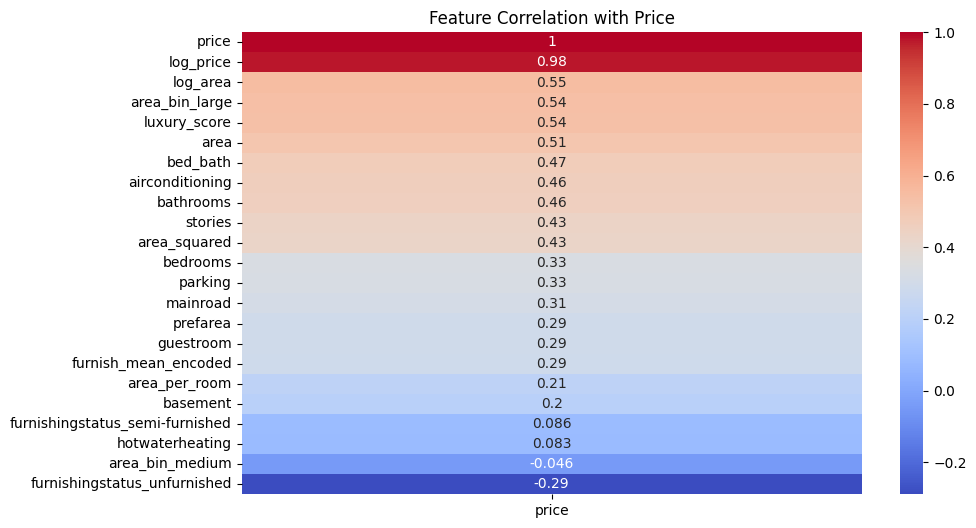

In [356]:
# Correlation with price
plt.figure(figsize=(10,6))
sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Price")
plt.show()

In [357]:
# Feature importance
model = RandomForestRegressor()
model.fit(X, y)

RandomForestRegressor()

In [358]:
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importance)

log_price                          0.999781
area_per_room                      0.000029
bedrooms                           0.000020
stories                            0.000018
area_squared                       0.000017
log_area                           0.000017
area                               0.000015
guestroom                          0.000012
basement                           0.000012
parking                            0.000011
furnishingstatus_semi-furnished    0.000011
bed_bath                           0.000011
luxury_score                       0.000008
prefarea                           0.000007
furnish_mean_encoded               0.000007
furnishingstatus_unfurnished       0.000006
airconditioning                    0.000004
bathrooms                          0.000004
area_bin_medium                    0.000003
area_bin_large                     0.000002
mainroad                           0.000002
hotwaterheating                    0.000002
dtype: float64


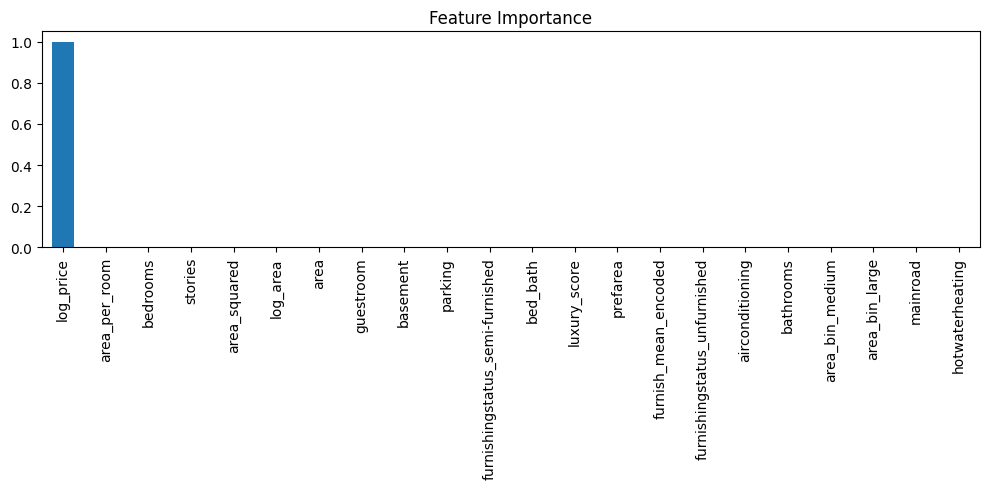

In [359]:
importance.plot(kind='bar', figsize=(10, 5), title='Feature Importance')
plt.tight_layout()
plt.show()

In [360]:
# Linear regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [361]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [362]:
y_pred = lr.predict(X_test)

In [363]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", rmse)

R2 Score: 0.9567821655896659
RMSE: 386842.2602378214


In [364]:
# Scalarization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [365]:
# Ridge regression
ridge = RidgeCV(alphas=[0.1, 1.0, 10.0])
ridge.fit(X_train_scaled, y_train)

RidgeCV(alphas=[0.1, 1.0, 10.0])

In [366]:
y_pred_ridge = ridge.predict(X_test_scaled)

In [367]:
print("Ridge Regression Results")
print("Best alpha:", ridge.alpha_)
print("R2 Score:", r2_score(y_test, y_pred_ridge))
mse = mean_squared_error(y_test, y_pred_ridge)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

Ridge Regression Results
Best alpha: 1.0
R2 Score: 0.9569487917178754
RMSE: 386095.80592809146


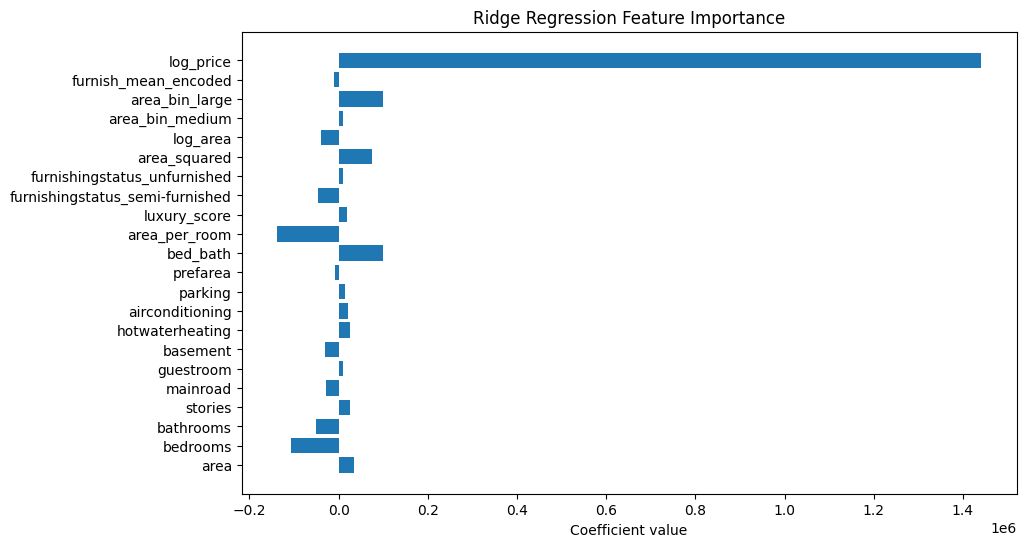

In [368]:
# Ridge coefficients
coef = ridge.coef_
features = X_train.columns

plt.figure(figsize=(10,6))
plt.barh(features, coef)
plt.xlabel("Coefficient value")
plt.title("Ridge Regression Feature Importance")
plt.show()

In [369]:
# Lasso regression
lasso = LassoCV(cv=5)
lasso.fit(X_train_scaled, y_train)

LassoCV(cv=5)

In [370]:
y_pred_lasso = lasso.predict(X_test_scaled)

In [371]:
print("\nLasso Regression Results")
print("Best alpha:", lasso.alpha_)
print("R2 Score:", r2_score(y_test, y_pred_lasso))
mse = mean_squared_error(y_test, y_pred_lasso)
rmse = np.sqrt(mse)
print("RMSE:", rmse)


Lasso Regression Results
Best alpha: 1488.5875050572129
R2 Score: 0.9564930420617643
RMSE: 388134.07373330113


In [372]:
print("Number of features used:", np.sum(lasso.coef_ != 0))

Number of features used: 19
